## Mot 17 verisetinden görselleri önce videoya çevireceğiz sonra da verisetinde verilen nesne kodlarını ve gt verilerini kullanarak nesne takibi yapacağız 

### 1 - img2video 

In [1]:
import cv2
import os 
from os.path import isfile, join
import matplotlib.pyplot as plt

(<matplotlib.image.AxesImage at 0x7fcd330a4640>, (-0.5, 1919.5, 1079.5, -0.5))

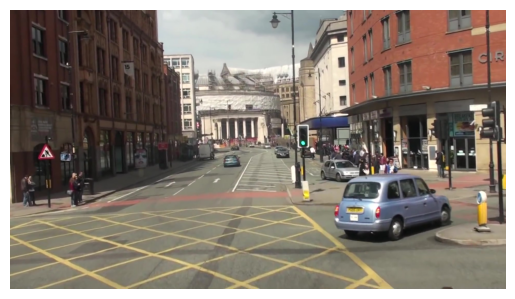

In [2]:
pathIn = r"img1"
pathOut = "MOT17-13-SDP.mp4"

# list comphrehension ile klasörden görselleri okuyoruz
files = [f for f in os.listdir(pathIn) if isfile(join(pathIn, f))]

# örnek bir görseli okuyoruz
img1 = cv2.imread(pathIn +"//"+ files[44])
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
plt.imshow(img1), plt.axis("off")


In [3]:
# görselleri videoya çeviriyoruz 
fps = 25 # frame per second, video hızı
size = (img1.shape[1], img1.shape[0]) 
# Video yazma işlemi için bir VideoWriter nesnesi oluşturuyoruz
out = cv2.VideoWriter(pathOut, cv2.VideoWriter_fourcc(*'mp4v'), fps, size, True) # true: renkli video

# tüm görselleri videoya çeviriyoruz
for i in files:
    filename = pathIn +"//"+ i
    img = cv2.imread(filename)
    out.write(img)
out.release()

### 2 - Object Tracking

In [2]:
# verisetinde bize sağlanan gt içinde her framedeki objelerin koordinatları ve idleri bulunmaktadır
# gt de bir nesne seçicez onun grand truth değerlerini üzerine çizdireceğiz

import pandas as pd
import cv2
import numpy as np
import matplotlib.pyplot as plt
import time 
import seaborn as sns

In [3]:
# gt dosyasındaki verilerin etiketleri 
col_list = ["frame_number", "identity_number", "left", "top", "width", "height", "score", "class", "visibility"]

# gt dosyasını okuyoruz
data = pd.read_csv("gt.txt",  names=col_list)

data.head()

,frame_number,identity_number,left,top,width,height,score,class,visibility
0,1,1,1376,485,37,28,0,11,1.0
1,2,1,1379,486,37,28,0,11,1.0
2,3,1,1382,487,38,29,0,11,1.0
3,4,1,1386,488,38,29,0,11,1.0
4,5,1,1389,490,38,29,0,11,1.0


In [7]:
# car sınıfındaki nesneleri seçiyoruz, car sınıf 3 numara buna veri setinin paperından erişebilirsiniz
from csv import writer


car = data[data["class"] == 3]

# videoyu okuyoruz
cap = cv2.VideoCapture("MOT17-13-SDP.mp4")

# takip edilecek nesnenin id değerini seçiyoruz
id1 = 29
numberOfImage = np.max(data["frame_number"])
fps = 25
bound_box_list = [] # nesnenin koordinatlarını tutacağımız liste

# video üzerinde takip gösterilmesi için video kayıt 
writer = cv2.VideoWriter("nesne_takibi.mp4", cv2.VideoWriter_fourcc(*'mp4v'), fps, (960,540))

for i in range(numberOfImage-1):

    ret, frame = cap.read()
    
    if ret:
        frame = cv2.resize(frame, dsize=(960,540)) # ekranı küçülttük

        filter_id1 = np.logical_and(car["frame_number"] == i+1, car["identity_number"] == id1)

        if len(car[filter_id1]) !=0:
            x = int(car[filter_id1].left.values[0]/2)
            y = int(car[filter_id1].top.values[0]/2)
            w = int(car[filter_id1].width.values[0]/2)
            h = int(car[filter_id1].height.values[0]/2)
            
            cv2.rectangle(frame, (x,y),(x+w,y+h),(0,255,0),2)
            cv2.circle(frame, (int(x+w/2),int(y+h/2)), 2, (0,0,255),-1)
            
            # frame, x, y, genis, yuksek, center_x, center_y
            bound_box_list.append([i, x,y,w,h,int(x+w/2),int(y+h/2)])
            
        cv2.putText(frame, "Frame num:"+str(i+1), (10,30), cv2.FONT_HERSHEY_SCRIPT_SIMPLEX,1,(0,0,255),2)

        
        time.sleep(0.01)
        # video kayıt
        writer.write(frame)   
    else: break

cap.release()
# nesne takibini "nesne_takibi.mp4" adıyla kaydettik
writer.release()       
  
# Takip ettiğimiz nesnenin grand truth değerlerini kaydediyoruz
df = pd.DataFrame(bound_box_list, columns = ["frame_no", "x", "y", "w", "h", "center_x", "center_y"])
      
df.to_csv("gt_new.txt",index=False)